In [1]:
import numpy as np
from skimage import data
from skimage . color import rgb2gray
import matplotlib . pyplot as plt
from mpl_toolkits . mplot3d import Axes3D
import cv2 as cv # librairie OpenCV
from tqdm import tqdm
from numba import njit
import time
from sklearn.linear_model import RANSACRegressor # modèle de RANSAC implémenté dans sklearn

In [16]:
@njit
def SAD(block1, block2):
    return np.abs(block1 - block2).sum()

@njit
def SSD(block1, block2):
    return (np.abs(block1 - block2)**2).sum()

@njit
def ZSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)
    # Subtract the mean from patch1 and patch2
    patch1_normalized = patch1 - mean1
    patch2_normalized = patch2 - mean2
    # Compute the squared differences
    squared_diff = np.square(patch1_normalized - patch2_normalized)
    # Calculate the sum of squared differences
    zssd_score = np.sum(squared_diff)
    return zssd_score

@njit
def ZNSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)

    patch1_normalized = (patch1 - mean1) / np.linalg.norm(patch1 - mean1)
    patch2_normalized = (patch2 - mean2) / np.linalg.norm(patch1 - mean1)

    squared_diff = np.square(patch1_normalized - patch2_normalized)
    nzssd_score = np.sum(squared_diff)

    return nzssd_score

In [3]:
@njit
def block_matching(Iref, Isearch, N, maxdisp, similarity):
    disp = np.zeros_like(Iref)
    margin = N//2
    for i in np.arange(margin,Iref.shape[0] - margin):
        for j in np.arange(margin, Iref.shape[1] - margin):
            ref_block = Iref[i-margin:i+margin+1,j-margin:j+margin+1]
            min_sad=np.inf
            min_pos=0
            for x_dec in np.arange(0, maxdisp):
                new_x = j-x_dec
                if new_x >= margin:
                    search_block = Isearch[i-margin:i+margin+1, new_x-margin:new_x+margin+1]
                    sad=similarity(ref_block, search_block)
                    if sad < min_sad:
                        min_sad=sad
                        min_pos=x_dec
            disp[i,j]=min_pos
    return disp

In [4]:
# Measure the execution time
@njit
def mode_filter(img, N=5):
    filtered_img = np.zeros_like(img)
    pas = N//2
    for i in np.arange(pas,img.shape [0]-pas):
        for j in np.arange(pas, img.shape [1]-pas):
            block = img[i-pas:i+pas+1,j-pas:j+pas+1]
            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k
    return filtered_img


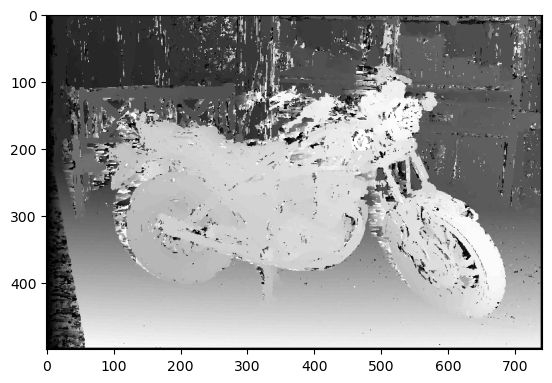

In [55]:
Ig, Id, gt = data.stereo_motorcycle()
maxdisp = 60
N = 5
disp = block_matching(rgb2gray(Ig), rgb2gray(Id), N, maxdisp, ZNSSD)
plt.imshow(disp, cmap="gray")

Execution time: 0.9358739852905273 seconds


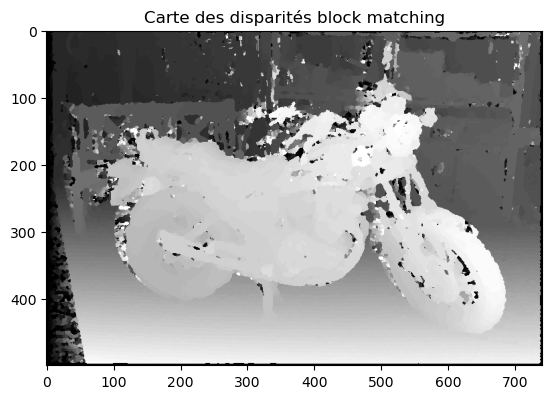

In [56]:
# test la fonction
start_time = time.time()
disp = mode_filter(disp, N)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
plt. figure ()
plt. imshow ( disp , cmap = "gray" )
plt. title ( "Carte des disparités block matching" )
plt.show()

Nombre de points sans disparité : 10833


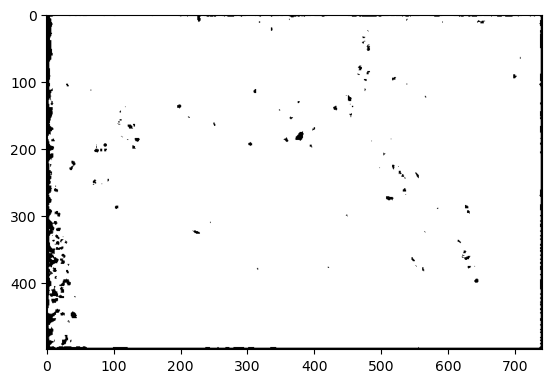

In [57]:
res1 = disp.copy()

mask = np.where((res1 > 0) & (res1 != -1), 1, 0).astype(bool)
num_no_disparity = np.sum(~mask)

print(f"Nombre de points sans disparité : {num_no_disparity}")
plt.imshow(mask, cmap="gray")

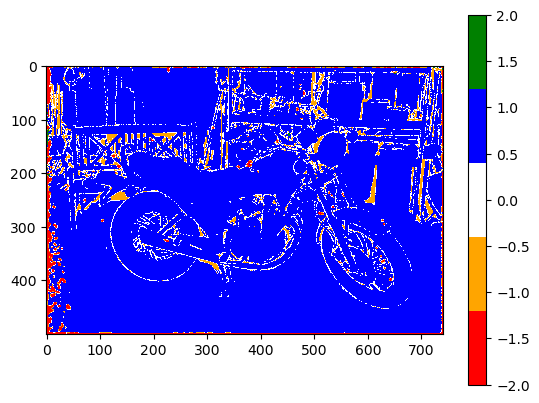

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Définition de la palette de couleurs personnalisée
occcmap = ListedColormap(["red", "orange", "white", "blue", "green"])

# Exemple de matrice de vérité gt et de masque M

M = mask

# Création de la carte d'évaluation des occultations
evaluation_map = np.zeros_like(gt, dtype=np.int8)

evaluation_map[(gt < np.inf) & (M == 1)] = 1  # Vrai négatif
evaluation_map[(gt < np.inf) & (M == 0)] = -2  # Faux positif
evaluation_map[(gt == np.inf) & (M == 1)] = -1  # Faux négatif
evaluation_map[(gt == np.inf) & (M == 0)] = 2  # Vrai positif

# Affichage de la carte d'évaluation des occultations
plt.imshow(evaluation_map, cmap=occcmap)
plt.colorbar()
plt.show()

In [59]:
# Calculer le masque des faux négatifs
false_negatives_mask = (res1 > 0) & (gt == np.inf)

# Compter le nombre de faux négatifs
false_negatives_count = np.count_nonzero(false_negatives_mask)

# Afficher le nombre de faux négatifs
print("Nombre de faux négatifs :", false_negatives_count)

Nombre de faux négatifs : 26548


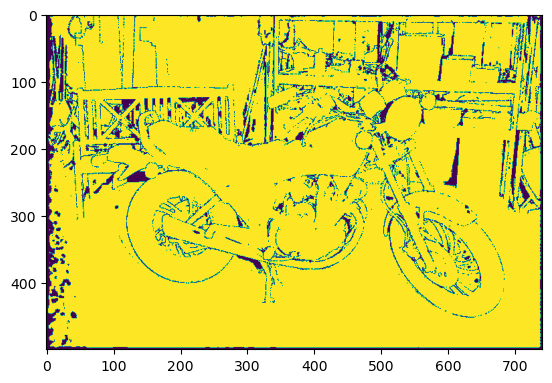

In [60]:
# Calculer le masque des points à considérer
mask_eval = M & (gt < np.inf)

# Afficher le masque des points à considérer
plt.imshow(mask_eval)

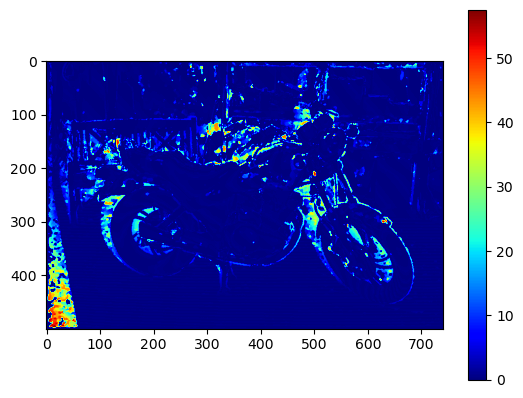

In [61]:
# Calculer la carte des différences absolues
diff_map = np.abs(res1 - gt)

# Fixer à 0 les points hors du masque M_eval
diff_map[~mask_eval] = 0

# Définir les bornes de l'échelle des pseudocouleurs
vmin = 0
vmax = np.max(diff_map)

# Afficher la carte des différences absolues
plt.imshow(diff_map, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [62]:
# Sélectionner les valeurs d'erreur de disparité correspondant aux points dans M_eval
errors = diff_map[mask_eval]

# Calculer les mesures d'erreur
mean_error = np.mean(errors)
median_error = np.median(errors)
min_error = np.min(errors)
max_error = np.max(errors)
std_error = np.std(errors)

# Afficher les mesures d'erreur
print("Erreur moyenne de disparité :", mean_error)
print("Erreur médiane de disparité :", median_error)
print("Erreur minimale de disparité :", min_error)
print("Erreur maximale de disparité :", max_error)
print("Écart-type d'erreur de disparité :", std_error)

Erreur moyenne de disparité : 2.5217354323024384
Erreur médiane de disparité : 0.31354331970214844
Erreur minimale de disparité : 0.0
Erreur maximale de disparité : 57.519386291503906
Écart-type d'erreur de disparité : 7.35853257759137


In [14]:
def initialize_stereo_matching(img_left, img_right):
    # Initialisation des détecteurs et des descripteurs SIFT
    sift = cv2.SIFT_create()
    
    # Détection des points d'intérêt et calcul des descripteurs pour chaque image
    keypoints_left, descriptors_left = sift.detectAndCompute(img_left, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(img_right, None)
    
    # Paramètres pour le matcher FLANN
    flann_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(flann_params, search_params)
    
    # Recherche des correspondances
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
    
    # Filtrage des correspondances basé sur le ratio de distance
    good_matches = []
    for match1, match2 in matches:
        if match1.distance < 0.7 * match2.distance:
            good_matches.append(match1)
    
    # Récupération des coordonnées des points correspondants
    left_pts = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches])
    right_pts = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches])
    
    return left_pts, right_pts

def propagate_correlation(keypoints_left, keypoints_right, valid_matches, img_left, img_right, block_size=5, num_disparities=16):
    height, width = img_left.shape
    disparity_map = np.zeros_like(img_left, dtype=np.float32)
    
    # Convertir les keypoints en coordonnées (x, y)
    keypoints_left_coords = np.array([kp.pt for kp in keypoints_left])
    keypoints_right_coords = np.array([kp.pt for kp in keypoints_right])
    
    for match in valid_matches:
        # Récupérer les coordonnées des keypoints correspondants
        x_left, y_left = keypoints_left_coords[match.queryIdx]
        x_right, y_right = keypoints_right_coords[match.trainIdx]
        
        # Convertir les coordonnées en entiers
        x_left = int(round(x_left))
        y_left = int(round(y_left))
        x_right = int(round(x_right))
        y_right = int(round(y_right))
        
        # Calculer les limites du bloc
        min_disp = max(0, x_left - num_disparities)
        max_disp = min(width, x_left + num_disparities)
        
        # Calculer la corrélation pour chaque disparité
        min_cost = np.inf
        best_disparity = 0
        
        for d in range(min_disp, max_disp):
            cost = 0
            
            for i in range(-block_size, block_size+1):
                for j in range(-block_size, block_size+1):
                    diff = int(img_left[y_left+i, x_left+j]) - int(img_right[y_right+i, x_right+j-d])
                    cost += abs(diff)
            
            if cost < min_cost:
                min_cost = cost
                best_disparity = d
        
        disparity_map[y_left, x_left] = best_disparity
    
    return disparity_map

def estimate_fundamental_matrix(keypoints_left, keypoints_right, valid_matches):
    # Convertir les keypoints en coordonnées (x, y)
    keypoints_left_coords = np.array([kp.pt for kp in keypoints_left])
    keypoints_right_coords = np.array([kp.pt for kp in keypoints_right])
    
    # Extraire les coordonnées des points correspondants
    correspondences_left = keypoints_left_coords[[match.queryIdx for match in valid_matches]]
    correspondences_right = keypoints_right_coords[[match.trainIdx for match in valid_matches]]
    
    # Estimer la matrice fondamentale à partir des correspondances
    F, _ = cv.findFundamentalMat(correspondences_left, correspondences_right, cv.FM_RANSAC)
    
    return F

def apply_ransac(keypoints_left, keypoints_right, valid_matches, confidence=0.99, max_trials=100, residual_threshold=1.0):
    # Convertir les keypoints en coordonnées (x, y)
    keypoints_left_coords = np.array([kp.pt for kp in keypoints_left])
    keypoints_right_coords = np.array([kp.pt for kp in keypoints_right])
    
    # Extraire les coordonnées des points correspondants
    correspondences_left = keypoints_left_coords[[match.queryIdx for match in valid_matches]]
    correspondences_right = keypoints_right_coords[[match.trainIdx for match in valid_matches]]
    
    # Appliquer RANSAC pour estimer les correspondances valides
    model = RANSACRegressor(max_trials=max_trials, residual_threshold=residual_threshold, stop_probability=confidence)
    model.fit(correspondences_left, correspondences_right)
    
    # Filtrer les correspondances erronées
    inlier_mask = model.inlier_mask_
    inliers_left = correspondences_left[inlier_mask]
    inliers_right = correspondences_right[inlier_mask]
    inliers_matches = [valid_matches[i] for i in range(len(valid_matches)) if inlier_mask[i]]
    
    return inliers_left, inliers_right, inliers_matches

def apply_constraints(disparity_map, img_left, img_right, window_size=5, disparity_range=16):
    # Appliquer des contraintes locales basées sur la cohérence de texture
    disparity_map_filtered = cv.filterSpeckles(disparity_map, 0, 0, max_disparity=disparity_range)
    
    # Appliquer des contraintes globales basées sur la cohérence spatiale
    disparity_map_filtered = cv.medianBlur(disparity_map_filtered, window_size)
    
    return disparity_map_filtered

In [3]:
# Chargement des images
Ig, Id, gt = data.stereo_motorcycle()
Ig_gray = cv.cvtColor(Ig, cv.COLOR_BGR2GRAY)
Id_gray = cv.cvtColor(Id, cv.COLOR_BGR2GRAY)

# Options
block_size = 5
num_disparities = 16
confidence = 0.95
max_trials = 100
residual_threshold = 1.0
window_size = 5
disparity_range = 16

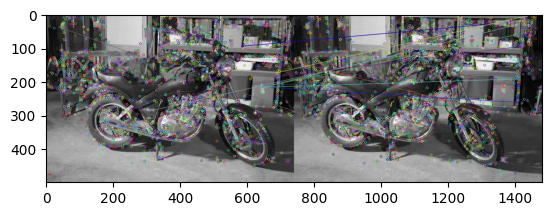

In [15]:
# Etape 1 : initialisation et affich
keypoints_left, keypoints_right, matchesMask = initialize_stereo_matching(Ig_gray, Id_gray)

# Dessiner les correspondances sur les images
matches = []
for i, match in enumerate(matchesMask):
    if match[0] == 1:  # Correspondance valide
        matches.append([cv.DMatch(i, i, 0)])

img_matches = cv.drawMatchesKnn(Ig_gray, keypoints_left, Id_gray, keypoints_right, matches, None)
plt.imshow(img_matches)

In [6]:
# Étape 2 : Propagation 2D avec corrélation
disparity_map = propagate_correlation(keypoints_left, keypoints_right, valid_matches, Ig_gray, Id_gray, block_size, num_disparities)

disparity_map

AttributeError: 'list' object has no attribute 'queryIdx'

In [53]:
# Étape 3 : Estimation de la matrice fondamentale
F = estimate_fundamental_matrix(keypoints_left, keypoints_right, valid_matches)
print(F)

[[ 1.27370608e-07 -6.36481454e-05  1.67594822e-02]
 [ 6.60068348e-05  5.15638703e-06 -1.63683587e-01]
 [-1.76761178e-02  1.58304427e-01  1.00000000e+00]]


In [55]:
# Étape 4 : RANSAC pour filtrer les correspondances erronées
inliers_left, inliers_right, inliers_matches = apply_ransac(keypoints_left, keypoints_right, valid_matches, confidence, max_trials, residual_threshold)

# Affichage des correspondances filtrées
img_inliers = cv.drawMatches(Ig_gray, inliers_left, Id_gray, inliers_right, inliers_matches, None)
plt.imshow(img_inliers)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
